In [5]:
import tensorflow.keras as keras
import numpy as np
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph
import pygraphviz
import graphviz
import evolutionary_keras.optimizers
import networkx as nx
plt.rcParams['figure.figsize'] = [15, 5]
# from RWNN import RWNNmodel

Using TensorFlow backend.


In [82]:
from tensorflow.python.eager import backprop
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.platform import tf_logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export

class removeSynapsesFF (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
        inputs =1
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=range(i+1,i+pc+1)
            for ind in inds:
                if ind != i and ind<units:
                    msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out

class removeSynapsesRR (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
        inputs =1
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(inputs, high=units, size=pc)
            for ind in inds:
                if ind != i:
                    msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out


class removeSynapses (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
#         msk=1-np.tri(units,units) #upperdiagonal mask
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(i+1, high=units, size=pc)
            for ind in inds:
                msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out

# class removeSynapses (Constraint):
#     def __init__(self, units,pc=3):
#         outputs=1
# #         msk=1-np.tri(units,units) #upperdiagonal mask
#         msk=np.zeros([units,units])
#         for i in range(units-outputs):
#             inds=np.random.randint(i+1, high=units, size=pc)
#             for ind in inds:
#                 msk[i][ind]=1
#         self.mask=tf.Variable(msk,dtype=tf.float32)
#     def __call__(self, w):
#         out=tf.multiply(self.mask,w)
#         V=tf.keras.backend.sum(out,axis=2)
#         print (V)
# #         print (tf.keras.backend.sum(out,axis=2,keepdims=True))
#         print (out)
#         print (tf.multiply(out, tf.expand_dims(V,1)))
#         return out/abs(tf.keras.backend.sum(out))*abs(tf.keras.backend.sum(w))


# class removeSynapses (Constraint):
#     def __init__(self, units,pc=0.5,ff=True):
# #         msk=1-np.tri(units,units) #upperdiagonal mask
#         msk=rng.rand(units,units)
#         msk[msk > pc] = 0
#         msk[msk != 0] = 1
#         if ff:
#             msk *= 1 - np.tri(*msk.shape)
#         for i in range(len(msk)):
#             if sum(msk[i])==0:
#                 msk[i][-1]=1
#         if ff:
#             msk *= 1 - np.tri(*msk.shape)
#         self.mask=tf.Variable(msk,dtype=tf.float32)
#     def __call__(self, w):
#         return tf.multiply(self.mask,w)

class RWNN(Layer):
  def __init__(self,
               units,
               outunits,
               activation=None,
               kernel_initializer='glorot_uniform',
               iters=10,
               kernel_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape'] = (kwargs.pop('input_dim'),)

    super(RWNN, self).__init__(
        activity_regularizer=regularizers.get(activity_regularizer), **kwargs)

    self.units = int(units) if not isinstance(units, int) else units
    self.outunits=outunits
    self.iters=iters           
    self.activation = activations.get(activation)
    self.use_bias = False
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    
    self.supports_masking = True
    self.input_spec = InputSpec(min_ndim=2)

  def build(self,input_shape):
    dtype = dtypes.as_dtype(self.dtype or K.floatx())
    self.inunits=input_shape[-1]
    self.kernel = self.add_weight(
        'kernel',
        shape=[self.units, self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        dtype=self.dtype,
        trainable=True)
#     self.kernel=self.kernel_constraint.__call__(self.kernel)
    self.built = True

  def call(self, inputs,verbose=False):
#     self.kernel=tf.multiply(self.mask,self.kernel)
    if verbose:
        outhistory=[]
    inputs = math_ops.cast(inputs, self._compute_dtype)
    rank = len(inputs.shape)
    if inputs.shape[0] != None:
        z =tf.zeros((inputs.shape[0],self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    else:
        z =tf.zeros((1,self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    outputs = tf.concat([inputs, z], 1)
    for j in range(self.iters):
        outputs = gen_math_ops.mat_mul(outputs, self.kernel)
        if self.activation is not None:
            outputs=self.activation(outputs)
        aux= tf.gather(outputs, [self.inunits + i for i in range(self.units-self.inunits)], axis=1)
        outputs=tf.concat([inputs, aux], 1)
        if verbose:
            outhistory.append(np.array(outputs))
#             print (outputs)
#         print (tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1))
    if verbose:
        return np.array(outhistory)
    return tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1)
    

  def compute_output_shape(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    input_shape = input_shape.with_rank_at_least(2)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError(
          'The innermost dimension of input_shape must be defined, but saw: %s'
          % input_shape)
    return input_shape[:-1].concatenate(self.outunits)
#     return self.outputs
  def plot_tree(self):
        G = nx.DiGraph(directed=True)
        idd=0
        #Nodes
        for i in range(self.inunits):
            G.add_node(idd,type='input',style='filled',fillcolor='red')
            idd+=1
        for i in range(self.units-self.outunits-self.inunits):
            if sum([self.kernel[i,idd] for i in range(self.units)]) != 0:
                G.add_node(idd,type='hidden')
            else:
                G.add_node(idd,type='bias',style='filled',fillcolor='magenta')
            idd+=1
        for i in range(self.outunits):
            G.add_node(idd,type='output',style='filled',fillcolor='blue')
            idd+=1
        #Connections
        for i in range(self.units):
            for j in range(self.units):
                weight=self.kernel[i,j]
                if weight != 0:
                    G.add_edge(i,j)
                    G[i][j]['penwidth']=abs(weight)
                    if weight >0:
                        G[i][j]['color']='green'
                    else:
                        G[i][j]['color']='red'

        #plot
        A = to_agraph(G)
        A.layout('dot')
        graphviz.Source(A).view()


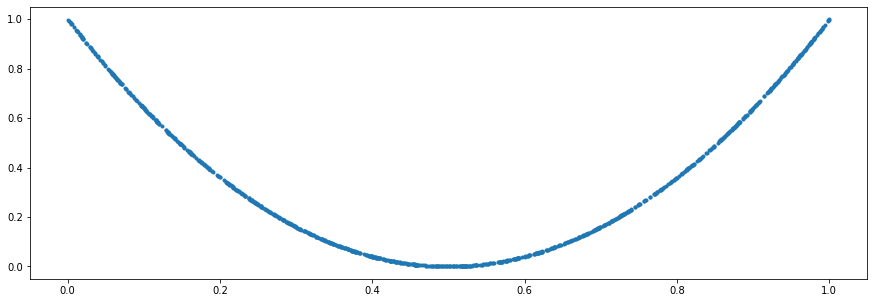

In [83]:
#1D
#simple 1d input -> 1d output training set (easy visualization)
seed=0
rng=np.random.RandomState(seed)
# x=2*rng.rand(1000,1)-1
# y=(x)**2

x=rng.rand(1000,1)
y=(2*(x-0.5))**2
plt.plot(x,y,'.',)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_38 (RWNN)               (1, 1)                    2500      
_________________________________________________________________
dense_38 (Dense)             (1, 1)                    1         
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/40
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.1278
Epoch 2/40
1000/1000 [==============================] - 0s 453us/sample - loss: 0.0902
Epoch 3/40
1000/1000 [==============================] - 0s 498us/sample - loss: 0.0894
Epoch 4/40
1000/1000 [==============================] - 0s 431us/sample - loss: 0.0876
Epoch 5/40
1000/1000 [==============================] - 0s 446us/sample - loss: 0.0864
Epoch 6/40
1000/1000 [==============================] - 1s

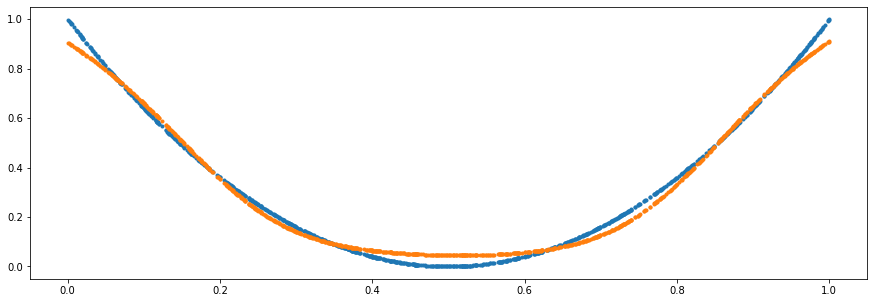

In [102]:
units=50
connections=50
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
model = Sequential() 
model.add(
    RWNN(units,1, 
         activation='sigmoid',
         input_shape=(1,),
         kernel_initializer=init,
         iters=10 #, 
         #kernel_constraint=removeSynapses(units,pc=connections)
        )) 
model.add(Dense(1, activation='linear',use_bias=False,kernel_initializer=init))
          
model.summary()

# opt = keras.optimizers.Adagrad(learning_rate=0.1)
opt = keras.optimizers.SGD(learning_rate=0.1)
# opt = evolutionary_keras.optimizers.NGA(population_size=10, sigma_original=15)

model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=8,
                    epochs=40,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

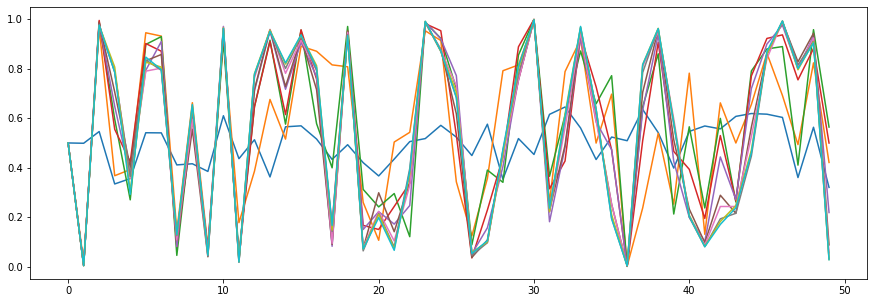

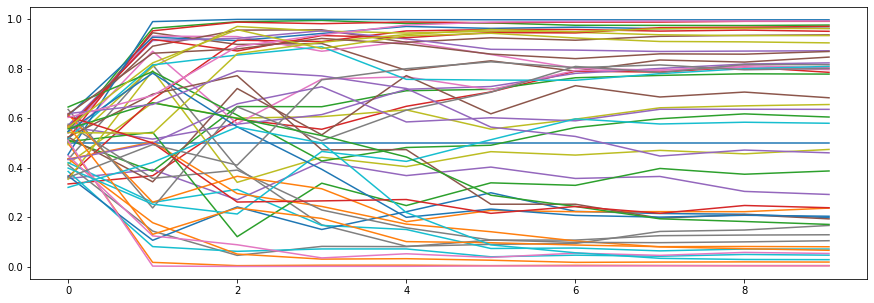

In [103]:
o=model.layers[0].call([[0.5]],verbose=True)
for oi in o:
    plt.plot(oi[0])
plt.figure()
for oi in o.transpose():
    plt.plot(oi[0])

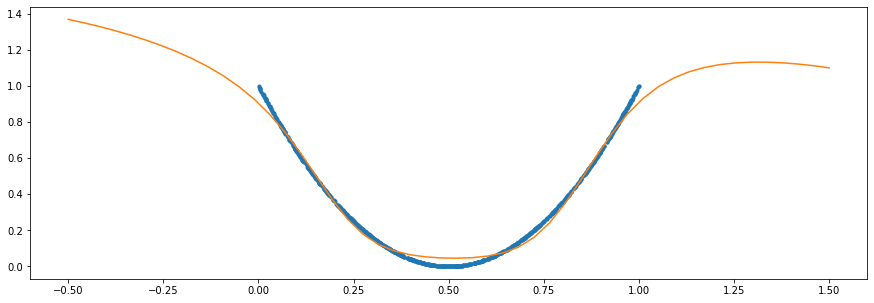

In [105]:
# model.layers[0].plot_tree()
xx=np.linspace(-0.5, 1.5, num=50)
yy=model.predict(xx,batch_size=len(xx))
plt.plot(x,y,'.')
plt.plot(xx,yy,'-')

In [1115]:
class removeSynapses (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
#         msk=1-np.tri(units,units) #upperdiagonal mask
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(i+1, high=units, size=pc)
            for ind in inds:
                msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        
        print (V2)
        print (V1)
        print (Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        print (out)
        print (tf.keras.backend.sum(out,axis=1))
        return out
k=removeSynapses(20)
k.__call__(model.layers[0].get_weights()[0])

tf.Tensor(
[-3.7636828   1.306529    1.4622831  -0.7100444  -2.1806304  -1.4464916
  1.172821   -0.5264728  -4.8839326  -1.1891308   5.139143    2.2901278
 -0.7609788  -3.534173   -0.33926508 -2.135209   -3.1173213  -0.5771899
 -1.2534275   0.        ], shape=(20,), dtype=float32)
tf.Tensor(
[-1.08256125e+00 -1.05140373e-01  2.98953354e-01  6.80997610e+00
 -9.42850471e-01  1.73501313e-01  2.32517576e+00 -1.16184115e-01
  1.84207201e+00  1.07502441e+02 -5.26824808e+00 -2.89510784e+01
  3.53482306e-01 -4.81262684e+00 -3.43846262e-01  1.65655003e+01
 -3.11732125e+00  7.72932386e+00 -1.25342751e+00  0.00000000e+00], shape=(20,), dtype=float32)
tf.Tensor(
[ 3.47664642e+00 -1.24265213e+01  4.89134216e+00 -1.04265325e-01
  2.31280613e+00 -8.33706474e+00  5.04401028e-01  4.53136635e+00
 -2.65132546e+00 -1.10614309e-02 -9.75493729e-01 -7.91033655e-02
 -2.15280604e+00  7.34354258e-01  9.86676633e-01 -1.28894940e-01
  1.00000000e+00 -7.46753439e-02  1.00000000e+00  0.00000000e+00], shape=(20,), d

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[-0.        , -0.0132158 , -0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -3.7504668 ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        , -0.        ],
       [ 0.        , -0.        ,  0.34026325, -0.        , -0.        ,
        -0.831767  ,  0.        , -0.        ,  0.        , -0.        ,
         1.7980329 ,  0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -4.1141324 ,  0.        ,  5.5764155 ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        ,  0.        , -0.        

In [1118]:
# Print Weights 
for layer in model.layers:
    print(layer.get_weights()[0])
    print(np.max(layer.get_weights()[0]))
    print(np.min(layer.get_weights()[0]))

[[-0.4351337  -0.0930228   0.85550827 -1.517499   -1.0634408   0.43088004
   0.3510309  -0.5912908  -0.5591174  -1.1558192   0.97020817 -0.6773373
   0.14868045 -0.3409372   0.31958783  0.36683965  0.09220474 -0.4736133
  -0.03844958 -0.41724694]
 [-0.92940617 -0.38008547 -0.03075518  0.08060838  0.65132123  0.19907956
  -0.35642037  0.52396375 -0.76383483  0.18623376 -0.39574352  0.7072875
   0.8937311   0.5511259  -0.37929425  0.34787047  0.07122826  0.97727895
   0.2874444  -0.9028488 ]
 [ 0.17834735  0.33720797  0.8707505   0.46083713  0.72348624  0.6870021
   0.8345304  -0.967261    0.51019686 -1.0588663   0.6250222  -0.60698336
  -0.8269932  -0.3742587  -0.22213425  0.6908879   0.18610197 -0.5735972
  -0.7462035   1.0551211 ]
 [-0.42813063  0.7982621  -0.76088315  0.97733986  0.299109   -0.58270025
   0.11628532  0.06146114 -0.7167449  -0.457922   -0.25819874  0.8939663
   0.23835152 -0.38209474 -0.09931035 -0.3492027  -0.2629249  -0.067233
   0.88115436 -0.6293425 ]
 [-0.1897041

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_178 (RWNN)              (1, 1)                    10000     
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.1277
Epoch 2/80
1000/1000 [==============================] - 0s 382us/sample - loss: 1.1817
Epoch 3/80
1000/1000 [==============================] - 0s 383us/sample - loss: 1.1817
Epoch 4/80
1000/1000 [==============================] - 0s 443us/sample - loss: 1.1817
Epoch 5/80
1000/1000 [==============================] - 0s 398us/sample - loss: 1.1817
Epoch 6/80
1000/1000 [==============================] - 0s 456us/sample - loss: 1.1817
Epoch 7/80
1000/1000 [==============================] - 0s 408us/sample - loss: 1.1817
Epoch 8/80
100

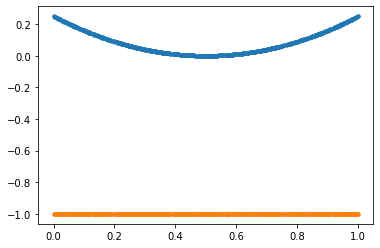

In [414]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(100,1, activation='tanh',input_shape=(1,),kernel_initializer=init,iters=10, kernel_constraint=removeSynapses(100))) 
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=10,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

In [894]:
pc=0.5
msk=rng.rand(10,10)
msk[msk > pc] = 0
msk[msk != 0] = 1

msk *= 1 - np.tri(*msk.shape)
msk

array([[0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [360]:
msk=np.ones([10,10])
for i in range(10):
    for j in range(10):
        if i>=j:
            msk[i,j]=0
msk

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [368]:
1-np.tri(10,10)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [402]:
from tensorflow.python.ops import gen_math_ops
gen_math_ops.mat_mul([[1,10,100]], 1-np.tri(3,3))

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[ 0,  1, 11]], dtype=int32)>

In [406]:
np.dot([1,10,100], np.ones([3,3]))

array([111., 111., 111.])

In [788]:
def sig(x):
    return 1 / (1 + np.exp(-x))
#     return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) 

In [789]:
sig(1)

0.7310585786300049

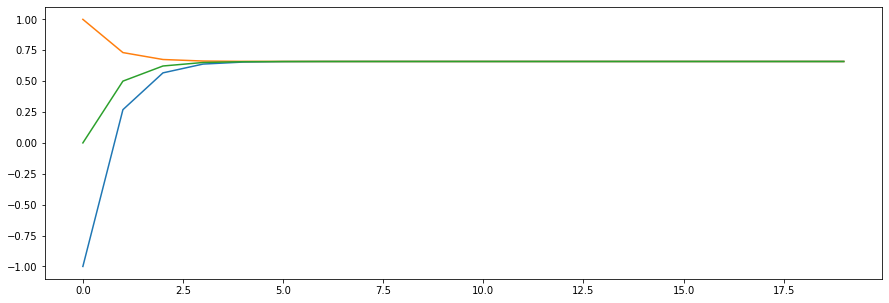

In [807]:
x = list(range(20))
y=[-1]
y2=[1]
y3=[0]
for i in x:
    y.append(sig(y[-1]))
    y2.append(sig(y2[-1]))
    y3.append(sig(y3[-1]))

plt.plot(x,y[:len(x)])
plt.plot(x,y2[:len(x)])
plt.plot(x,y3[:len(x)])

In [808]:
y

[-1,
 0.2689414213699951,
 0.5668330070205946,
 0.6380320873724359,
 0.6543084758952321,
 0.6579807100202137,
 0.6588066371986613,
 0.6589922651251212,
 0.6590339784724807,
 0.6590433517412365,
 0.6590454579604421,
 0.659045931237306,
 0.6590460375846879,
 0.6590460614814077,
 0.6590460668511046,
 0.6590460680576988,
 0.6590460683288258,
 0.6590460683897492,
 0.6590460684034389,
 0.6590460684065151,
 0.6590460684072064]

In [928]:
np.random.randint(2, high=5, size=20)

array([4, 4, 3, 4, 2, 2, 3, 4, 4, 4, 4, 2, 4, 4, 2, 4, 3, 3, 3, 4])

In [78]:
list(range(1,3+1))

[1, 2, 3]